## Lab 7: Implementing a Convolutional Neural Network Using Keras

In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2" # suppress info and warning messages
import tensorflow.keras as keras
import math
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

A very common problem in computer vision is recognizing hand-written digits. The images of numerals are commonly used by data scientists and machine learning experts to train supervised learning models that specialize in decoding human handwriting. This is a classic problem that is often used in exercises and documentation. In this lab, you will train a convolutional neural network to classify hand-written digits. You will complete the following tasks:

1. Define your ML problem:
    * Define the label - what are you predicting?
    * Identify the features
2. Import the data and split the data into training and test data sets
3. Inspect and visualize the data
3. Prepare your data so that it is ready for modeling.
5. Construct a convolutional neural network
6. Train the convolutional neural network.
7. Evaluate the neural network model's performance on the training and test data.

For this lab, use the demo <i>Implementing a Neural Network Using Keras</i> that is contained in this unit as a reference.

**<font color='red'>Note: some of the code cells in this notebook may take a while to run</font>**


## Part 1. Define Your ML Problem 

We will implement a convolutional neural network to solve a handwriting recognition problem. The neural network will classify a hand-written digit. 

#### Define the Label

We will work with the MNIST data set, a famous collection of images used for handwriting recognition. It contains labeled images of handwritten digits from 0 to 9. Therefore, the label is a digit from 0 and 9. This is a multiclass classification problem. 


#### Identify Features

Each example corresponds to one hand-written image. The features will be comprised of numerical feature vectors (an n-dimensional array) that contain grey-scale pixel values that range from 0 to 255.



## Part 2. Import the Data Set and Create Training and Test Sets

The MNIST data set comes preloaded in Keras. The `load_data()` function returns the data set split into training and test subsets. The cell below loads the data set and contains training and test data.


In [2]:
# The mnist data set comes preloaded 
mnist = keras.datasets.mnist

# Create training and test sets
(X_train, y_train),(X_test, y_test) = mnist.load_data()


### Inspect the Data

<b>Task</b>: In the code cell below, inspect the datatype and dimensions (shape) of the training and test data (`X_train`, `y_train`, `X_test`, `y_test`). 

In [3]:
# YOUR CODE HERE 
print(f"X_train is of type {X_train.dtype} and shape {X_train.shape}")
print(f"y_train is of type {y_train.dtype} and shape {y_train.shape}")
print(f"X_test is of type {X_test.dtype} and shape {X_test.shape}")
print(f"y_test is of type {y_test.dtype} and shape {y_test.shape}")

X_train is of type uint8 and shape (60000, 28, 28)
y_train is of type uint8 and shape (60000,)
X_test is of type uint8 and shape (10000, 28, 28)
y_test is of type uint8 and shape (10000,)


Notice that the training and test data sets are NumPy arrays. 

* <b>Training data:</b><br>
    `X_train` is a three-dimensional array of shape `(60000, 28, 28)`. It contains grayscale image data. Pixel values range from 0 to 255.<br>
    `y_train` is a one-dimensional array with shape `(6000,)`. It contains digit labels (integers in range 0-9).


* <b>Test data:</b><br>
    `X_test` is a three-dimensional array of shape `(10000, 28, 28)`. It contains grayscale image data. Pixel values range from 0 to 255.<br>`y_test` is a one-dimensional array with shape `(1000,)`. It contains digit labels (integers in range 0-9).

Let's take a look at the data in more detail. Let's inspect the first example (which contains an image) in `X_train`:


In [4]:
X_train[0].shape

(28, 28)

In [ ]:
X_train[0]

As expected, the first example in the training data is a 28 x 28 array.  This array encodes the grayscale value of the  hand-written image, i.e., each entry in the 28 x 28 array encodes the intensity (darkness) of the corresponding pixel. 

### Visualize the Data

Let's visualize an image below.

<b>Task</b>: In the code cell below, use the Seaborn`heatmap()` function to display any image contained in `X_train`.

<AxesSubplot: >

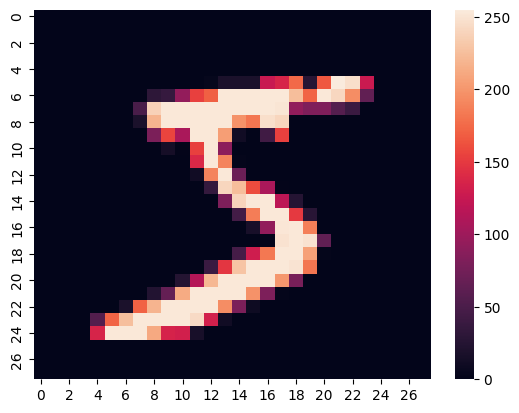

In [6]:
# YOUR CODE HERE
sns.heatmap(X_train[0])

<b>Task</b>: Inspect the corresponding label in `y_train` to confirm that the label matches the image you see in the heatmap above.

In [7]:
# YOUR CODE HERE
y_train[0]

5

<b>Task</b>: Which digit appeared in your heatmap? Did it match its label? Record your findings in the cell below.

the digit in the heatmap seems to be a 5 which matches the label.

We've created a function `plot_imgs()` to help us visualize the image data. Let's use this function to inspect a few more examples in the training data. Execute the two code cells below.

In [8]:
# Function to visualize the data
def plot_imgs(images, labels=None):
    subplots_x = int(math.ceil(len(images) / 5))
    plt.figure(figsize=(10,2*subplots_x))
    for i in range(min(len(images), subplots_x*5)):
        plt.subplot(subplots_x,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        if labels is not None:
            plt.xlabel(labels[i])
    plt.show()
    

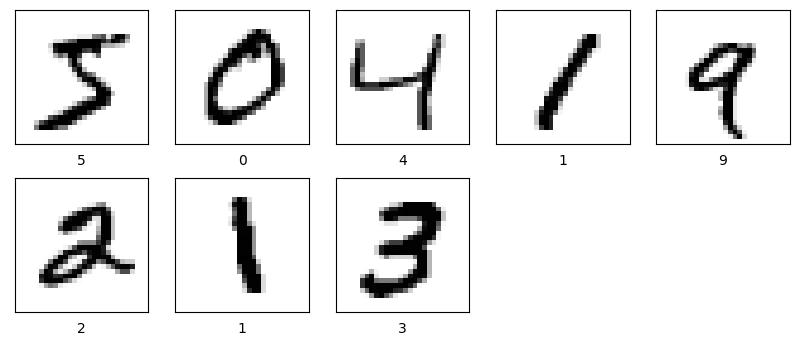

In [9]:
# Visualize some training examples
plot_imgs(X_train[:8], y_train[:8])

## Part 3. Prepare the Data

Let's now prepare our data to be suitable for a CNN.

#### Scale the Data

Our MNIST data is raw data containing pixel values between 0 and 255. Neural networks process inputs using small weight values, and inputs with large integer values can disrupt or slow down the training process. Therefore, it is a good practice to normalize the pixel values so that each pixel has a value between 0 and 1. This can be done by dividing all pixels values by the largest pixel value; that is 255. 

<b>Task:</b> In the code cell below, normalize the pixel values in `X_train` and `X_test` to be between 0 and 1 by dividing all feature values by 255.0.

In [10]:
# YOUR CODE HERE
X_train = X_train / 255.0
X_test = X_test / 255.0

#### Reshape the Data
A CNN in Keras requires a 4-dimensional array as input in the form: `(num_examples, image_dimension_X, image_dimension_Y, num_channels)`.

Since grayscale has only one color channel, every example in `X_train` would have the shape `(28, 28, 1)`. `X_test` should have the same dimensions.

<b>Task:</b> In the code cell below: 
1. reshape every example in `X_train` to have the shape `(num_examples_X_train, 28, 28, 1)`.
1. reshape every example in `X_test` to have the shape `(num_examples_X_test, 28, 28, 1)`.

<i>Hint:</i> use the NumPy `reshape()` function. Consult the online [documentation](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html) for more information.

In [11]:
# YOUR CODE HERE
X_train = np.reshape(X_train, (X_train.shape[0], 28, 28, 1))
X_test = np.reshape(X_test, (X_test.shape[0], 28, 28, 1))

## Part 4. Construct the Convolutional Neural Network

### Step 1. Define Model Structure

Next we will create our convolutional neural network structure. A CNN has three different types of hidden layers: a convolutional layer, a pooling layer, and a fully connected layer. When constructing a convolutional hidden layer, we will compose a 2D convolution, followed by a batch normalization, followed by an activation function. 

Let's create the CNN structure (Note that there are different ways one can choose to construct a CNN in Keras). We will create an input layer, five hidden layers and an output layer:

* <b>Input layer</b>: The input layer will have the input shape corresponding to the number of features. 
* <b>Hidden layers</b>: We will create five hidden layers:
    * Four hidden layers will be convolutional layers. They will be comprised of a 2D convolution, followed by a batch normalization, followed by an activation function. In this case, the activation function of choice is ReLU.
    * One hidden layer will be a pooling layer. We will add a layer that uses Global Average Pooling. This is a pooling operation designed to replace the final fully connected layer in classical CNN. 
* <b>Output layer</b>: The output layer will have a width of 10. 

To construct the CNN model using Keras, we will do the following:

* As before, we will use the Keras `Sequential` class to group a stack of layers. This will be our CNN model object. For more information, consult the Keras online [Sequential class documentation](https://keras.io/api/models/sequential/#sequential-class).
* We will use the `InputLayer` class to create the input layer. For more information, consult the Keras online [InputLayer class documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/InputLayer).
* We will use the `Conv2D` class to create the convolutional layers. For more information, consult the Keras online [Conv2D class documentation](https://keras.io/api/layers/convolution_layers/convolution2d/).
    * For batch normalization, we will use the `BatchNormalization` class. For more information, consult the Keras online [BatchNormalization class documentation](https://keras.io/api/layers/normalization_layers/batch_normalization/).
    * For the activation function, we will use the `ReLU` class. For more information, consult the Keras online [ReLU class documentation](https://keras.io/api/layers/activation_layers/relu/).
* We will use the `GlobalAveragePooling2D` class to create the pooling layer. For more information, consult the Keras online [GlobalAveragePooling2D class documentation](https://keras.io/api/layers/pooling_layers/global_average_pooling2d/
).
* Finally, we will use the `Dense` class to create the output layer. For more information, consult the Keras online [Dense class documentation](https://keras.io/api/layers/core_layers/dense/).
* We will add each layer to the CNN model object.


<b>Task:</b> Follow these steps to complete the code in the cell below:

1. Create the CNN model object. 
    * Use ``keras.Sequential() `` to create a model object, and assign the result to the variable ```cnn_model```.
    
      
2. Create the input layer: 
    * Call `keras.layers.InputLayer()` with the argument `input_shape` to specify the dimensions of the input. In this case, the dimensions will be the shape of each example (image) in `X_train` &mdash; assign this value to the argument `input_shape`. 
    * Assign the result to the variable `input_layer`.
    * Add `input_layer` to the neural network model object `cnn_model`.
    

3. Create the first convolutional layer. You will accomplish this by doing the following:
    * Call `keras.layers.Conv2D()` and assign the result to the variable `conv_1`. You will pass two arguments to `Conv2D()`:
        1. The number of filters: `Conv2D()` requires an argument indicating the number of filters in the convolution. Layers in the network architecture that are closer to the input layer learn fewer convolutional filters whereas layers closer to the output layer learn more filters. Let's choose a value of 16 for the first layer. 
        2. The kernal size: this argument specifies the size of the convolution window. We will choose a kernal size of 3.
    * Call `keras.layers.BatchNormalization()` without arguments. Assign the result to variable `batchNorm_1`.
    * Call `keras.layers.ReLU()` without arguments. Assign the result to avariable `ReLU_1`.    
    * Add each of these items (`conv_1`, `batchNorm_1` and `ReLU_1`) in order to the neural network model object `cnn_model`.
    

4. Create the second convolutional layer using the same approach that you used to create the first convolutional layer, specifying 32 filters and a kernal size of 3. Add the layer to the neural network model object `cnn_model`.

    
5. Create the third convolutional layer using the same approach that you used to create the first convolutional layer, specifying 64 filters and a kernal size of 3. Add the layer to the neural network model object `cnn_model`.

    
6. Create the fourth convolutional layer using the same approach that you used to create the first convolutional layer, specifying 128 filters and a kernal size of 3. Add the layer to the neural network model object `cnn_model`. 

    
7. Create the pooling layer:
    * Call `keras.layers.GlobalAveragePooling2D()` without arguments.
    * Assign the result to the variable `pooling_layer`.
    * Add `pooling_layer` to the neural network model object `cnn_model`. 
  
  
8. Create the output layer:
    * Call `keras.layers.Dense()`. We will have one node per class. We have ten classes (digits from 0-9). Therefore, when creating the output later, specify 10 units. Do not specify an activation function.
    * Assign the result to the variable `output_layer`.
    * Add `output_layer` to the neural network model object `cnn_model`. 
  

In [14]:
# 1. Create CNN model object

# YOUR CODE HERE
cnn_model = keras.Sequential()

# 2. Create the input layer and add it to the model object: 
# YOUR CODE HERE
input_layer = keras.layers.InputLayer(input_shape=(28, 28, 1))
cnn_model.add(input_layer)

# 3. Create the first convolutional layer and add it to the model object:
# YOUR CODE HERE
conv_1 = keras.layers.Conv2D(16, 3)
batchNorm_1 = keras.layers.BatchNormalization()
ReLU_1 = keras.layers.ReLU()

cnn_model.add(conv_1)
cnn_model.add(batchNorm_1)
cnn_model.add(ReLU_1)

# 4. Create the second convolutional layer and add it to the model object:
# YOUR CODE HERE
conv_2 = keras.layers.Conv2D(32, 3)
batchNorm_2 = keras.layers.BatchNormalization()
ReLU_2 = keras.layers.ReLU()

cnn_model.add(conv_2)
cnn_model.add(batchNorm_2)
cnn_model.add(ReLU_2)

# 5. Create the third convolutional layer and add it to the model object:
# YOUR CODE HERE
conv_3 = keras.layers.Conv2D(64, 3)
batchNorm_3 = keras.layers.BatchNormalization()
ReLU_3 = keras.layers.ReLU()

cnn_model.add(conv_3)
cnn_model.add(batchNorm_3)
cnn_model.add(ReLU_3)

# 6. Create the fourth convolutional layer and add it to the model object:
# YOUR CODE HERE
conv_4 = keras.layers.Conv2D(128, 3)
batchNorm_4 = keras.layers.BatchNormalization()
ReLU_4 = keras.layers.ReLU()

cnn_model.add(conv_4)
cnn_model.add(batchNorm_4)
cnn_model.add(ReLU_4)

# 7. Create the pooling layer and add it to the model object:
# YOUR CODE HERE
pooling_layer = keras.layers.GlobalAveragePooling2D()
cnn_model.add(pooling_layer)

# 8. Create the output layer and add it to the model object:
# YOUR CODE HERE
output_layer = keras.layers.Dense(10)
cnn_model.add(output_layer)

cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
batch_normalization_2 (Batch (None, 26, 26, 16)        64        
_________________________________________________________________
re_lu_2 (ReLU)               (None, 26, 26, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
batch_normalization_3 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
re_lu_3 (ReLU)               (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 22, 22, 64)       

### Step 2. Define the Optimization Function

<b>Task:</b> In the code cell below, create a stochastic gradient descent optimizer using  `keras.optimizers.SGD()`. Specify a learning rate of 0.1 using the `learning_rate` parameter. Assign the result to the variable`sgd_optimizer`.

In [15]:
sgd_optimizer = keras.optimizers.SGD(learning_rate = 0.1)# YOUR CODE HERE

### Step 3. Define the loss function

<b>Task:</b> In the code cell below, create a sparse categorical cross entropy loss function using `keras.losses.SparseCategoricalCrossentropy()`. This is an extension of the categorical cross entropy loss function. It is used when there are two or more label classes and the labels are integers. For more information, consult the online [SparseCategoricalCrossentropy documentation](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy). Use the parameter `from_logits=True`. Assign the result to the variable  `loss_fn`.

In [16]:
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits = True)# YOUR CODE HERE

### Step 4. Compile the model

<b>Task:</b> In the code cell below, package the network architecture with the optimizer and the loss function using the `cnn_model.compile()` method. Specify the optimizer, loss function and the accuracy evaluation metric as arguments.

In [17]:
cnn_model.compile(optimizer=sgd_optimizer, loss = loss_fn, metrics = ['accuracy'])# YOUR CODE HERE

## Part 5. Fit the Model to the Training Data

We can now fit the CNN model to the training data. Since there are 60,000 training examples and nearly 100,000 parameters to fit, this may take a while to run. Therefore, we will only choose one epoch in this assignment.

<b>Task:</b> In the code cell below, fit the CNN model to the training data using the `fit()` method. Call `cnn_model.fit()` with the following arguments:
1. The training data sets.
2. The number of epochs.

Save the results to the variable `history`. 

<b>Note</b>: This may take a while to run.

In [18]:
num_epochs = 1 # Number of epochs

t0 = time.time() # start time

history = cnn_model.fit(X_train, y_train, num_epochs)# YOUR CODE HERE 

t1 = time.time() # stop time

print('Elapsed time: %.2fs' % (t1-t0))

60000/60000 [==============================] - 181s 3ms/step - loss: 0.2675 - accuracy: 0.9129
Elapsed time: 181.45s


## Part 6. Evaluate the Model's Performance

Let's now evaluate our CNN model's performance on our test data and see how it did.


<b>Task:</b> In the code cell below, call the `cnn_model.evaluate()` method with the test data sets as arguments. The `evaluate()` method returns a list containing two values. The first value is the loss and the second value is the accuracy score. 


In [19]:
loss, accuracy = cnn_model.evaluate(X_test, y_test)# YOUR CODE HERE 

print('Loss: ', str(loss) , 'Accuracy: ', str(accuracy))

313/313 [==============================] - 3s 10ms/step - loss: 1.8205 - accuracy: 0.6073
Loss:  1.8205080032348633 Accuracy:  0.6072999835014343


Next we'll make some predictions on the test set and see for ourselves how accurate these predictions are.

<b>Task:</b> In the code cell below, call the `plot_imgs()` functions with the first 25 images in `X_test` as the first argument, and the first 25 labels in `predictions` as the second argument. 

The result should be a display of the first 25 images in the test set `X_test`, and below each image, a display of the predicted digit. How well did we do?

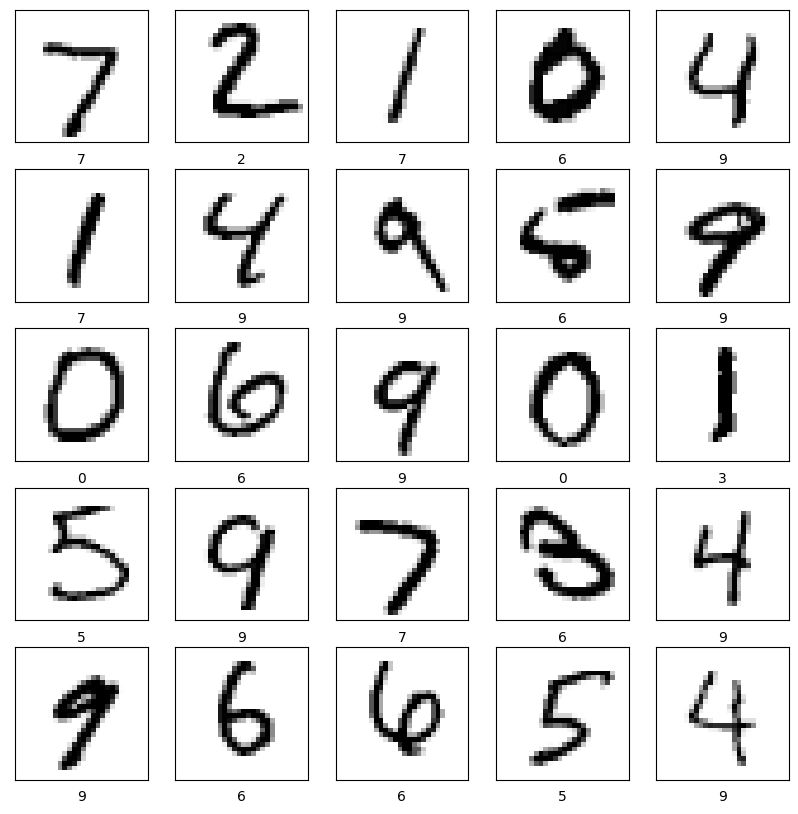

In [20]:
# Make predictions on the test set
logits = cnn_model.predict(X_test)
predictions = logits.argmax(axis = 1)


## Plot individual predictions
# YOUR CODE HERE
plot_imgs(X_test[:25], predictions[:25])